# From Square-Root Law to Dynamic Trade Effects

## 1. The dataset

From binance cryptocurrency api via the binance-LOB repository (https://github.com/pfei-sa/binance-LOB/tree/main)

Quotes data with a depth of 100 into the LOB timestamp, ask price, ask volume, bid price, bid volume, midpoint, spread

Trades data withtimestamp, price, volume, trade sign (-1 = sell, 1 = buy)

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 
from scipy.optimize import minimize
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
# # Fetch LOB data from Binance 
# # https://github.com/pfei-sa/binance-LOB.git

# os.chdir('/home/smn/repos/fintech_price_impact/binance-LOB/')
# from replay import orderbook_generator, get_snapshots_update_ids, diff_depth_stream_generator

# snapshot_ids = get_snapshots_update_ids("BTCUSDT")

# lob_depth = 100
# batch_size = 1000
# batch_data = []

# # Build db structure from order book 
# # Each iter is a new row.
# for orderbook in orderbook_generator(0, "BTCUSDT", block_size=5000):

#     timestamp = orderbook.timestamp

#     asks = orderbook.asks
#     ask_price = []
#     ask_volume = []
#     for key, value in asks.items():
#         ask_price.append(key)
#         ask_volume.append(value)

#     bid_price = []
#     bid_volume = []
#     bids = orderbook.bids
#     for key, value in bids.items():
#         bid_price.append(key)
#         bid_volume.append(value)

#     best_ask = ask_price[0]
#     best_bid = bid_price[0]

#     row = {'timestamp': timestamp}
#     for i in range(len(ask_price)):
#         row[f'ask_price_depth_{i}'] = ask_price[i]
#         row[f'ask_volume_depth_{i}'] = ask_volume[i]

#     if len(ask_price) > lob_depth:
#         ask_price = ask_price[:lob_depth]
#         ask_volume = ask_volume[:lob_depth]
#     else:
#         while len(ask_price)<lob_depth:
#             ask_price.append(np.nan)

#     for i in range(len(bid_price)):
#         row[f'bid_price_depth_{i}'] = bid_price[i]
#         row[f'bid_volume_depth_{i}'] = bid_volume[i]
#     row['midpoint'] = (best_ask + best_bid) / 2
#     row['spread'] = best_ask - best_bid

#     if len(bid_price) > lob_depth:
#         bid_price = bid_price[:lob_depth]
#         bid_volume = bid_volume[:lob_depth]
#     else:
#         while len(bid_price)<lob_depth:
#             bid_price.append(np.nan)
    
#     batch_data.append(row)

#     if len(batch_data) >= batch_size:
#         batch_df = pd.DataFrame(batch_data)
#         batch_df.to_csv(f'batch_{i//batch_size}.csv', index=False)
#         batch_data = []

# # merging the files
# joined_files = os.path.join("/home/smn/repos/fintech_price_impact/data", "batch*.csv")
# joined_list = glob.glob(joined_files)

# quotes_df = pd.concat(map(pd.read_csv, joined_list), ignore_index=True)
# quotes_df['timestamp'] = pd.to_datetime(quotes_df['timestamp'])
# quotes_df = quotes_df.sort_values('timestamp').reset_index(drop=True)

# quotes_df.to_csv('data/quotes.csv', index=False)

# snapshot_ids = get_snapshots_update_ids("BTCUSDT")

# trades = []

# for diff_data in diff_depth_stream_generator(0, 'BTCUSDT', block_size = 5000): 
#     timestamp, first_update_id, final_update_id, diff_bids_volume, diff_bids_price, diff_asks_volume, diff_asks_price, symbol = diff_data

#     # BIDS
#     for price, quantity in zip(diff_bids_price, diff_bids_volume): 
#         trades.append({
#             'timestamp': timestamp,
#             'trade_price': price,
#             'trade_volume': abs(quantity),
#             'trade_sign': -1,
#             'update_id': final_update_id
#         })

#     # ASKS
#     for price, quantity in zip(diff_asks_price, diff_asks_volume): 
#         trades.append({
#             'timestamp': timestamp,
#             'trade_price': price,
#             'trade_volume': abs(quantity),
#             'trade_sign': 1,
#             'update_id': final_update_id
#         })

# trades_df = pd.DataFrame(trades)
# trades_df['timestamp'] = pd.to_datetime(trades_df['timestamp'])
# trades_df = trades_df.sort_values('timestamp').reset_index(drop=True)

# # Concat trades with the same timestamp
# # maybe?

# trades_df.to_csv(f'trades.csv', index=False)
# trades_df.head()

In [2]:
trades_df = pd.concat([
    pd.read_csv(file, header=None, names=[
        'trade_id', 'price', 'volume', 'quote_volume', 
        'timestamp', 'is_buyer_maker', 'is_best_match'
    ]) for file in glob.glob(os.path.join("data/binance_raw", "BTCUSDT-trades*.csv"))
], ignore_index=True)

trades_df['timestamp'] = pd.to_datetime(trades_df['timestamp'], unit='ns')
trades_df['price'] = trades_df['price'].astype(float)
trades_df['volume'] = trades_df['volume'].astype(float)
trades_df['trade_sign'] = trades_df['is_buyer_maker'].apply(lambda x: -1 if x else 1)
trades_df = trades_df.drop(columns=['is_buyer_maker', 'is_best_match'], axis=1)

print(trades_df.head())
print(trades_df.shape)

ohlvc_df = pd.concat([
    pd.read_csv(file, header=None, names=[
                'open_time', 'open', 'high', 'low', 'close', 'volume',
                'close_time', 'quote_volume', 'count', 'taker_buy_volume',
                'taker_buy_quote_volume', 'ignore'
    ]) for file in glob.glob(os.path.join("data/binance_raw", "BTCUSDT-1s*.csv"))
], ignore_index=True)

ohlvc_df['open_time'] = pd.to_datetime(ohlvc_df['open_time'], unit='ns')
ohlvc_df['close_time'] = pd.to_datetime(ohlvc_df['close_time'], unit='ns')
ohlvc_df['midpoint'] = (ohlvc_df['high'] + ohlvc_df['low'])/2
ohlvc_df['spread'] = 2 * (ohlvc_df['high'] - ohlvc_df['low'])

print(ohlvc_df.head())
print(ohlvc_df.shape)


     trade_id      price   volume  quote_volume                     timestamp  \
0  5129304097  112546.35  0.00018     20.258343 1970-01-21 07:16:19.200039304   
1  5129304098  112546.35  0.00005      5.627318 1970-01-21 07:16:19.200046122   
2  5129304099  112546.35  0.00005      5.627318 1970-01-21 07:16:19.200046122   
3  5129304100  112546.35  0.00005      5.627318 1970-01-21 07:16:19.200046122   
4  5129304101  112546.35  0.00005      5.627318 1970-01-21 07:16:19.200046122   

   trade_sign  
0           1  
1           1  
2           1  
3           1  
4           1  
(7408539, 6)
                open_time       open       high        low      close  \
0 1970-01-21 07:14:52.800  113297.92  113297.93  113297.92  113297.93   
1 1970-01-21 07:14:52.801  113297.93  113297.93  113284.79  113284.79   
2 1970-01-21 07:14:52.802  113284.78  113284.79  113284.78  113284.79   
3 1970-01-21 07:14:52.803  113284.78  113284.79  113284.78  113284.79   
4 1970-01-21 07:14:52.804  113284.79  1

# Data analysis

## 1. Baseline Implementation
- Square-Root Law: ΔP = Y σ√(Q/V)
- Parameter estimation and statistical validation
- Identify systematic deviations and failure modes

In [3]:
prices = trades_df['price'].values
signs = trades_df['trade_sign'].values
volumes = np.log(trades_df['volume'].values)

max_lag = min(1000, len(signs)//4)
lags = np.arange(1, max_lag)
correlations = []

mean_sign = np.mean(signs)
for lag in lags:
    c = np.mean(signs[:-lag] * signs[lag:]) - mean_sign**2
    correlations.append(c)

correlations = np.array(correlations)

# print(correlations)

# Fit power law: C₀(ℓ) ≈ C₀/ℓ^γ
valid = correlations > 0
if valid.sum() > 10:
    log_corr = np.log(correlations[valid])
    log_lags = np.log(lags[valid])

    coeffs = np.polyfit(log_lags, log_corr, 1)
    gamma = -coeffs[0]
    
    C0 = np.exp(coeffs[1])
    print(f"γ = {gamma:.3f}, C₀ = {C0:.4f}")

response = []
for lag in lags:
    if lag < len(prices):
        price_changes = prices[lag:] - prices[:-lag]
        r = np.mean(price_changes * signs[:-lag])
        response.append(r)

response = np.array(response)

# print(response)


γ = 0.714, C₀ = 11.8449


## 2. Propagator Model
- Propagator Model: P(t) = ∑G(t-s)ε(s)
- Temporal impact analysis (temporary vs permanent)
- Trade information content effects

In [4]:
# P(t) = Σ G₀(t-s) ε(s) ln(V(s))
def propagator_function(t, t0=20, beta=0.4, Gamma0=0.001):
    """G₀(t) = Γ₀ * t₀^β / (t₀ + t)^β"""
    return Gamma0 * (t0**beta) / ((t0 + t)**beta)

# Theoretical response function
def theoretical_response(lags, C0, gamma, t0=20, beta=0.4, Gamma0=0.001):
    """R(ℓ) using Eq. 17 from the paper"""
    R_theory = []
    
    for lag in lags:
        # Direct term
        term1 = propagator_function(lag, t0, beta, Gamma0)
        
        # Correlation terms
        term2 = 0
        for n in range(1, min(lag, 100)):
            if n < len(correlations):
                corr = C0 / (n**gamma) if n > 0 else C0
                term2 += propagator_function(lag - n, t0, beta, Gamma0) * corr
        
        R_theory.append(term1 + term2)
    
    return np.array(R_theory)

def fit_propagator(params):
    t0, beta, Gamma0 = params
    if beta <= 0 or beta >= 1 or t0 <= 0 or Gamma0 <= 0:
        return 1e6
    
    R_pred = theoretical_response(lags[:len(response)], C0, gamma, t0, beta, Gamma0)
    return np.sum((response - R_pred)**2)

Mean reversion: 

- β >> β_critical indicates a strong anti-persistance. The impact of trades decays immediatly.
- β << β_critical indicates a strong persistance. Trades have a long term impact.

In [5]:
# Initial guess: critical condition β = (1-γ)/2
beta_critical = (1 - gamma) / 2
result = minimize(fit_propagator, [20, beta_critical, 0.001], 
                 bounds=[(1, 100), (0.1, 0.9), (1e-6, 0.1)])

t0_fit, beta_fit, Gamma0_fit = result.x
print(f"Fitted: t₀={t0_fit:.1f}, β={beta_fit:.3f}, Γ₀={Gamma0_fit:.6f}")
print(f"Critical β = {beta_critical:.3f}")


Fitted: t₀=100.0, β=0.100, Γ₀=0.098781
Critical β = 0.143


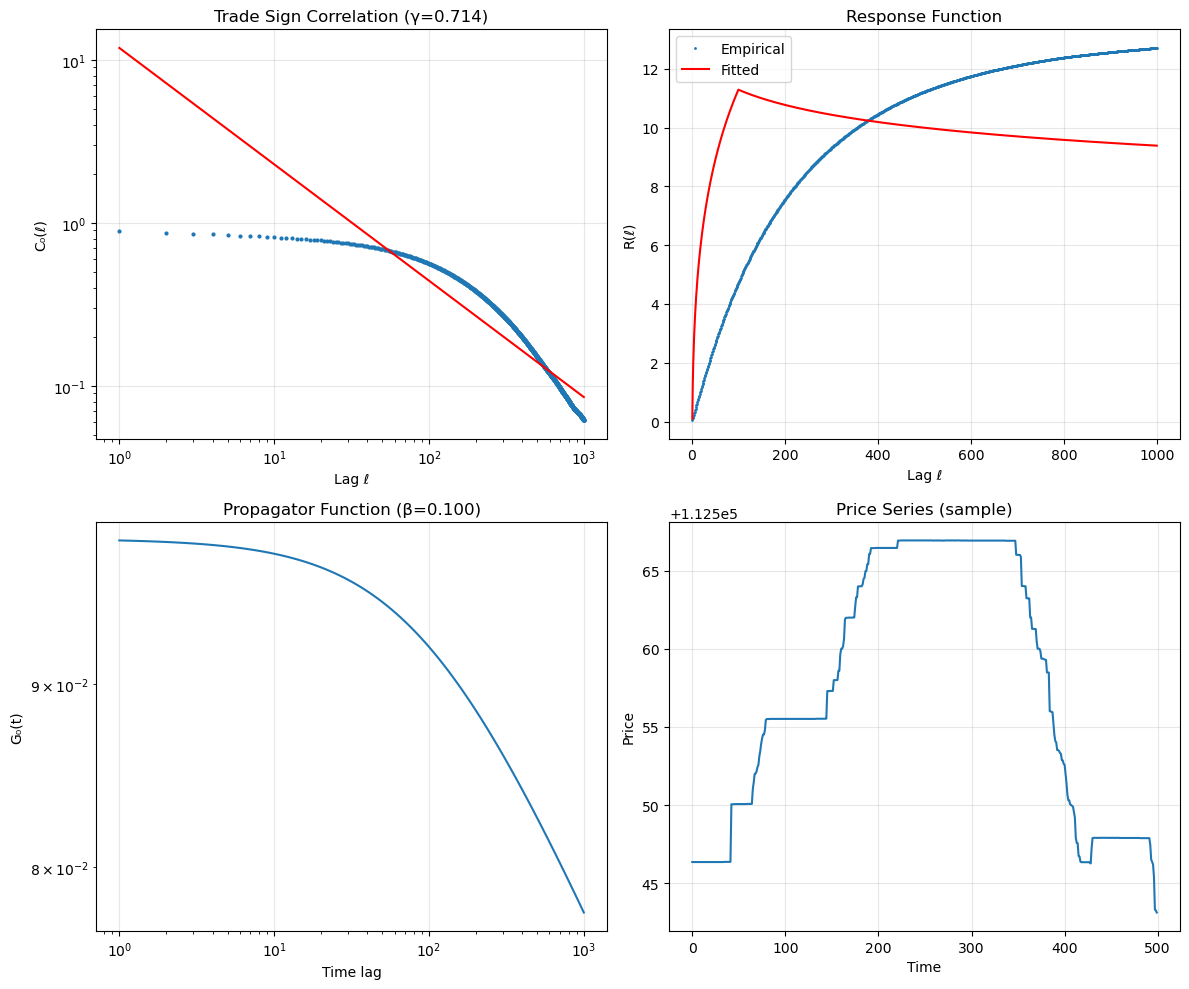

In [6]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Trade sign correlations
ax1.loglog(lags[valid], correlations[valid], 'o', markersize=2)
ax1.loglog(lags[valid], C0 / lags[valid]**gamma, 'r-')
ax1.set_xlabel('Lag ℓ')
ax1.set_ylabel('C₀(ℓ)')
ax1.set_title(f'Trade Sign Correlation (γ={gamma:.3f})')
ax1.grid(True, alpha=0.3)

# Response function
R_fitted = theoretical_response(lags[:len(response)], C0, gamma, t0_fit, beta_fit, Gamma0_fit)
ax2.plot(lags[:len(response)], response, 'o', markersize=1, label='Empirical')
ax2.plot(lags[:len(response)], R_fitted, 'r-', label='Fitted')
ax2.set_xlabel('Lag ℓ')
ax2.set_ylabel('R(ℓ)')
ax2.set_title('Response Function')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Propagator function
t_range = np.logspace(0, 3, 100)
G0_values = [propagator_function(t, t0_fit, beta_fit, Gamma0_fit) for t in t_range]
ax3.loglog(t_range, G0_values)
ax3.set_xlabel('Time lag')
ax3.set_ylabel('G₀(t)')
ax3.set_title(f'Propagator Function (β={beta_fit:.3f})')
ax3.grid(True, alpha=0.3)

# Price series sample
ax4.plot(prices[:500])
ax4.set_xlabel('Time')
ax4.set_ylabel('Price')
ax4.set_title('Price Series (sample)')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 3. ML Implementation
- Features: Volatility metrics, volume patterns, spreads, order book imbalance, decay patterns from propagator analysis
- Target: Direct price impact ΔP prediction
- Models: Compare ML predictions vs Square-root law vs Propagator model

In [7]:
# compute midpoint and spread for trades_df (match timestamps with ohlcv)

In [8]:
def create_features(trades_df, lookback=20):
    """Simple feature creation"""
    features = []
    
    for i in range(lookback, len(trades_df)-10):
        window = trades_df.iloc[i-lookback:i]
        current_trade = trades_df.iloc[i]
        
        # Basic features
        feature_row = {
            # Current trade
            'volume': current_trade['volume'],
            'log_volume': np.log(current_trade['volume']),
            'trade_sign': current_trade['trade_sign'],
            'spread': current_trade['spread'],
            
            # Historical patterns (lookback window)
            'avg_volume': window['volume'].mean(),
            'vol_ratio': current_trade['volume'] / window['volume'].mean(),
            'price_volatility': window['price'].pct_change().std(),
            'avg_spread': window['spread'].mean(),
            'sign_imbalance': window['epsilon'].mean(),
            
            # Target variable (price impact over next 10 trades)
            'price_impact': ((trades_df['price'].iloc[i+10] - trades_df['price'].iloc[i]) 
                           * current_trade['epsilon'] / trades_df['price'].iloc[i])
        }
        
        features.append(feature_row)
    
    return pd.DataFrame(features)

df = create_features(trades_df)


KeyError: 'spread'

In [ ]:
feature_cols = ['volume', 'log_volume', 'trade_sign', 'spread', 'avg_volume', 
                'vol_ratio', 'price_volatility', 'avg_spread', 'sign_imbalance']

X = df[feature_cols]
y = df['price_impact']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=feature_cols)

print("Features prepared and scaled")
print(f"X shape: {X_scaled.shape}")
print(f"y shape: {y.shape}")


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, shuffle=False  # Don't shuffle for time series
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# Random forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)


In [ ]:
# ΔP = Y * σ * sqrt(Q/V) * sign

Y_param = 0.1  # This should come from your Phase 1 calibration

# Calculate baseline predictions
baseline_pred = []
for i in range(len(X_test)):
    Q = X_test['volume'].iloc[i]
    V = X_test['avg_volume'].iloc[i] 
    sigma = X_test['price_volatility'].iloc[i]
    sign = X_test['trade_sign'].iloc[i]
    
    sqrt_impact = Y_param * sigma * np.sqrt(Q / V) * sign
    baseline_pred.append(sqrt_impact)

baseline_pred = np.array(baseline_pred)
print("Square-Root Law baseline calculated")


In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name}:")
    print(f"  MSE: {mse:.6f}")
    print(f"  R²: {r2:.4f}")
    return mse, r2

print("Model Performance:")
print("="*50)

lr_mse, lr_r2 = evaluate_model(y_test, lr_pred, "Linear Regression")
rf_mse, rf_r2 = evaluate_model(y_test, rf_pred, "Random Forest")
bl_mse, bl_r2 = evaluate_model(y_test, baseline_pred, "Square-Root Law")


In [ ]:
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance (Random Forest):")
print(feature_importance)


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Feature importance
axes[0,0].barh(feature_importance['feature'], feature_importance['importance'])
axes[0,0].set_title('Feature Importance')
axes[0,0].set_xlabel('Importance')

# Model comparison
models = ['Linear Reg', 'Random Forest', 'Square-Root Law']
mse_scores = [lr_mse, rf_mse, bl_mse]
r2_scores = [lr_r2, rf_r2, bl_r2]

axes[0,1].bar(models, mse_scores)
axes[0,1].set_title('Model Comparison (MSE)')
axes[0,1].set_ylabel('MSE')
axes[0,1].tick_params(axis='x', rotation=45)

# Predictions vs actual
axes[1,0].scatter(y_test[:100], rf_pred[:100], alpha=0.6, label='Random Forest')
axes[1,0].scatter(y_test[:100], baseline_pred[:100], alpha=0.6, label='Square-Root Law')
axes[1,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[1,0].set_xlabel('Actual Impact')
axes[1,0].set_ylabel('Predicted Impact')
axes[1,0].set_title('Predictions vs Actual (First 100 samples)')
axes[1,0].legend()

# Residuals
residuals_rf = y_test - rf_pred
axes[1,1].scatter(rf_pred, residuals_rf, alpha=0.6)
axes[1,1].axhline(y=0, color='r', linestyle='--')
axes[1,1].set_xlabel('Predicted Impact')
axes[1,1].set_ylabel('Residuals')
axes[1,1].set_title('Residuals Plot (Random Forest)')

plt.tight_layout()
plt.show()

## 4. Regime-Dependent Analysis
- Identify market conditions where traditional models underperform
- Cross-validation framework across different market regimes
- Performance comparison metrics focusing on model failure cases